In [13]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np
from torchvision.transforms import ToTensor

In [14]:
data_train = torchvision.datasets.MNIST('./data',download=True, train=True,transform=ToTensor())
data_test = torchvision.datasets.MNIST('./data',download=True, train=False,transform=ToTensor())

train_loader = torch.utils.data.DataLoader(data_train, batch_size=128)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=64)

In [15]:
def train_epoch(net, dataloader, lr = 0.01, optimizer =None, loss_fn = nn.NLLLoss()):
    optimizer = torch.optim.Adam(net.parameters(), lr = lr)
    net.train()
    total_loss, acc, count = 0,0,0
    for features, labels in dataloader:
        optimizer.zero_grad()
        out = net(features)
        loss = loss_fn(out,labels)
        loss.backward()
        optimizer.step()
        total_loss += loss
        _,predicted = torch.max(out,1)
        acc += (predicted == labels).sum()
        count += len(labels)
    return total_loss.item()/count, acc.item()/count

def validate(net, dataloader, loss_fn = nn.NLLLoss()):
    net.eval()
    count,acc,loss = 0,0,0
    with torch.no_grad():
        for features, labels in dataloader:
            out = net(features)
            loss += loss_fn(out,labels)
            pred = torch.max(out,1)[1]
            acc += (pred == labels).sum()
            count += len(labels)
    return loss.item()/count, acc.item()/count

In [16]:
def train(net,train_loader,test_loader,optimizer=None,lr=0.01,epochs=10,loss_fn=nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    res = { 'train_loss' : [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for ep in range(epochs):
        tl,ta = train_epoch(net,train_loader,optimizer=optimizer,lr=lr,loss_fn=loss_fn)
        vl,va = validate(net,test_loader,loss_fn=loss_fn)
        print(f"Epoch {ep:2}, Train acc={ta:.3f}, Val acc={va:.3f}, Train loss={tl:.3f}, Val loss={vl:.3f}")
        res['train_loss'].append(tl)
        res['train_acc'].append(ta)
        res['val_loss'].append(vl)
        res['val_acc'].append(va)
    return res

In [17]:
class OneConv(nn.Module):
    def __init__(self):
        super(OneConv, self).__init__()
        self.conv = nn.Conv2d(in_channels=1,out_channels=9,kernel_size=(5,5))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(5184,10)

    def forward(self, x):
        x = nn.functional.relu(self.conv(x))
        x = self.flatten(x)
        x = nn.functional.log_softmax(self.fc(x),dim=1)
        return x

net = OneConv()
summary(net,input_size=(1,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
OneConv                                  --                        --
├─Conv2d: 1-1                            [1, 9, 24, 24]            234
├─Flatten: 1-2                           [1, 5184]                 --
├─Linear: 1-3                            [1, 10]                   51,850
Total params: 52,084
Trainable params: 52,084
Non-trainable params: 0
Total mult-adds (M): 0.19
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.21
Estimated Total Size (MB): 0.25

In [18]:
hist = train(net,train_loader,test_loader,epochs=5)

Epoch  0, Train acc=0.951, Val acc=0.977, Train loss=0.001, Val loss=0.001
Epoch  1, Train acc=0.979, Val acc=0.978, Train loss=0.001, Val loss=0.001
Epoch  2, Train acc=0.986, Val acc=0.978, Train loss=0.000, Val loss=0.001
Epoch  3, Train acc=0.988, Val acc=0.977, Train loss=0.000, Val loss=0.001
Epoch  4, Train acc=0.991, Val acc=0.971, Train loss=0.000, Val loss=0.002


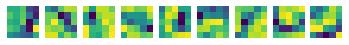

In [19]:
fig,ax = plt.subplots(1,9)
with torch.no_grad():
    p = next(net.conv.parameters())
    for i,x in enumerate(p):
        ax[i].imshow(x.detach().cpu()[0,...])
        ax[i].axis('off')

In [20]:
class MultilayerCNN(nn.Module):
    def __init__(self):
        super(MultilayerCNN,self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(10, 20, 5)
        self.fc = nn.Linear(320, 10)
    def forward(self,x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1,320)
        x = nn.functional.log_softmax(self.fc(x),dim=1)
        return x
net = MultilayerCNN()
summary(net,input_size=(1,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
MultilayerCNN                            --                        --
├─Conv2d: 1-1                            [1, 10, 24, 24]           260
├─MaxPool2d: 1-2                         [1, 10, 12, 12]           --
├─Conv2d: 1-3                            [1, 20, 8, 8]             5,020
├─MaxPool2d: 1-4                         [1, 20, 4, 4]             --
├─Linear: 1-5                            [1, 10]                   3,210
Total params: 8,490
Trainable params: 8,490
Non-trainable params: 0
Total mult-adds (M): 0.47
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.03
Estimated Total Size (MB): 0.09

In [21]:
hist = train(net,train_loader,test_loader,epochs=5)

Epoch  0, Train acc=0.951, Val acc=0.978, Train loss=0.001, Val loss=0.001
Epoch  1, Train acc=0.981, Val acc=0.977, Train loss=0.001, Val loss=0.001
Epoch  2, Train acc=0.985, Val acc=0.982, Train loss=0.000, Val loss=0.001
Epoch  3, Train acc=0.986, Val acc=0.983, Train loss=0.000, Val loss=0.001
Epoch  4, Train acc=0.987, Val acc=0.984, Train loss=0.000, Val loss=0.001


In [22]:
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [23]:
trainset = torchvision.datasets.CIFAR10(root='./dataCIFAR', train=True, download=True, transform=transform)

100.0%


Extracting ./dataCIFAR/cifar-10-python.tar.gz to ./dataCIFAR


In [24]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=14, shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=14, shuffle=False)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100.0%


Extracting ./data/cifar-10-python.tar.gz to ./data


In [27]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16,120,5)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(120,64)
        self.fc2 = nn.Linear(64,10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = nn.functional.relu(self.conv3(x))
        x = self.flat(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = LeNet()

summary(net,input_size=(1,3,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    --                        --
├─Conv2d: 1-1                            [1, 6, 28, 28]            456
├─MaxPool2d: 1-2                         [1, 6, 14, 14]            --
├─Conv2d: 1-3                            [1, 16, 10, 10]           2,416
├─MaxPool2d: 1-4                         [1, 16, 5, 5]             --
├─Conv2d: 1-5                            [1, 120, 1, 1]            48,120
├─Flatten: 1-6                           [1, 120]                  --
├─Linear: 1-7                            [1, 64]                   7,744
├─Linear: 1-8                            [1, 10]                   650
Total params: 59,386
Trainable params: 59,386
Non-trainable params: 0
Total mult-adds (M): 0.66
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 0.24
Estimated Total Size (MB): 0.30

In [28]:
opt = torch.optim.SGD(net.parameters(),lr=0.001,momentum=0.9)
hist = train(net, trainloader, testloader, epochs=3, optimizer=opt, loss_fn=nn.CrossEntropyLoss())

Epoch  0, Train acc=0.213, Val acc=0.234, Train loss=0.147, Val loss=0.143
Epoch  1, Train acc=0.237, Val acc=0.242, Train loss=0.143, Val loss=0.142
Epoch  2, Train acc=0.239, Val acc=0.259, Train loss=0.142, Val loss=0.139
